# Stat 143 Final Project

## Elo System for 9-ball Pool

Dasha Metropolitansky, Seth Billiau, Sarah Lucioni


We aim to create a ranking for 9-ball pool using data from 2010-2020. In our background research, we did not find an Elo system currently in use for 9-ball pool rankings. An Elo system is likely a good application in pool because it is a zero-sum game. In this project, we first calibrate a basic Elo system, apply a handful of improvements, then extend our ranking scheme to a Glicko2 system. 

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import csv
from datetime import datetime
import math

# Elo 

In [2]:
# Load validation dataset (from a 2021 tournament) 
val_data = pd.read_csv('data/predatorCLPClean.csv')
val_data['date'] = pd.to_datetime(val_data['date'])

# Load the entire dataset (years 2010 - 2020)
fulldf = pd.read_csv("data/fulldf.csv")
fulldf['date'] = pd.to_datetime(fulldf['date'])


In [3]:
val_data.head()

,Unnamed: 0,matchIndex,playerA,playerB,playerARacks,playerBRacks,playerARacks.1,date,competition
0,0,1,Chris Melling,Ralf Souquet,5,0,5,2021-03-22,2021 Predator CLP
1,1,2,Albin Ouschan,Chris Robinson,5,2,5,2021-03-22,2021 Predator CLP
2,2,3,Kelly Fisher,Niels Feijen,5,4,5,2021-03-22,2021 Predator CLP
3,3,4,Eklent Kaci,Albin Ouschan,5,4,5,2021-03-22,2021 Predator CLP
4,4,5,Niels Feijen,Chris Robinson,5,3,5,2021-03-22,2021 Predator CLP


In [4]:
# Elo Rating System 
# Constants
INITIAL_RATING = 1500
ELO_WIDTH = 400
K = 50

# List of player names
players = pd.concat([fulldf.playerA, fulldf.playerB])
print(players.value_counts().index.unique())

# Total number of players
nplayers = len(players.value_counts())
nplayers

Index(['Shane Van Boening', 'Niels Feijen', 'Jayson Shaw', 'Eklent Kaci',
       'Ralf Souquet', 'Albin Ouschan', 'Joshua Filler', 'Alex Kazakis',
       'David Alcaide', 'Denis Grabe',
       ...
       'Phillip Tieu', 'Ray Feliciano', 'Khalid Alghamdi', 'Admir Muho',
       'Michael Evans', 'ciech Szewczyk', 'Tommi Harmaala', 'Chistian Coffey',
       'Richie Orem', 'Konstantin Koukiadakis'],
      dtype='object', length=1276)


1276

In [5]:
def expected(A, B, ELO_WIDTH = ELO_WIDTH):
    '''
    Calculate player A's expected score which is equivalent to the probability that player A wins in this 
    pool scenario since we do not track draws.
    (https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details)
    
    params
    A: Player A's current elo rating
    B: Player B's current elo rating
    ELO_WIDTH: Elo system rating change constant
    
    return 
    proba: the probability that player A wins
    '''
    proba = 1 / (1 + 10 ** ((B - A) / ELO_WIDTH))
    return proba


def update_elo(winner_elo, loser_elo, K, ELO_WIDTH = ELO_WIDTH):
    '''
    Update the winner and loser elo ratings.
    
    params
    winner_elo: Winning player's elo rating at time of match
    loser_elo: Losing player's elo rating at time of match
    K: Update parameter
    ELO_WIDTH: Elo system rating change constant
    
    return 
    winner_elo: Winning player's updated elo rating
    loser_elo: Losing player's updated elo rating
    '''
    expected_win = expected(winner_elo, loser_elo, ELO_WIDTH)
    change_in_elo = K * (1 - expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo


def get_winner_loser(row):
    '''
    Get the winner and loser of the match. The winner is the player with more racks. Matches are played until 
    one player wins X number of racks (typically 5, 6, or 9).
    
    params
    row: Match in dataframe
    
    return 
    winner: Match winner's name
    loser: Match loser's name
    '''
    if row['playerARacks'] > row['playerBRacks']: 
        winner = row["playerA"]
        loser = row["playerB"]
    else: 
        winner = row['playerB']
        loser = row['playerA']
        
    return winner, loser


def run_tournament(data=fulldf, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, K=K):
    '''
    Construct Elo system for 9-ball pool by running through 10 years of matches (2010-2020).
    
    params
    data: Dataframe of 9-ball pool matches
    INITIAL_RATING: Initial rating for all players
    ELO_WIDTH: Elo system rating change constant
    K: Update parameter
    
    return 
    ratings: Elo ratings of all players
    '''  
    players = pd.concat([data.playerA, data.playerB])
    nplayers = len(players.value_counts())

    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)))

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner, loser = get_winner_loser(row)
        
        # Update Elo ratings
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], K, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating
        
    ratings = pd.DataFrame.from_dict(elo_ratings, orient='index')
    ratings = ratings.rename(columns={0: "ratings"})
    return ratings

In [6]:
ratings = run_tournament(fulldf)
ratings.sort_values(by='ratings', ascending = False)[0:25]

,ratings
Jayson Shaw,1994.756772
Eklent Kaci,1959.642140
Fedor Gorst,1869.983846
Joshua Filler,1849.676165
Maximilian Lechner,1848.250182
Niels Feijen,1823.510416
Mieszko Fortunski,1790.651954
Denis Grabe,1779.190459
Shane Van Boening,1764.965991
Jeffrey de Luna,1760.924804


In [7]:
# Players in the validation set
players_val = pd.concat([val_data.playerA, val_data.playerB])

In [8]:
def get_CLPratings(ratings):
    '''
    Get the players in the validation set and in the training data plus their corresponding predicted Elo ratings.
    
    params
    ratings: Elo ratings based on training data
    
    return
    CLPratings: Elo ratings for the players in the validation set
    val_players_names: Players in the validation set and in the training data
    val_players_idx: Indices of players in both the validation and training data
    '''
    # Get players index
    val_players_idx = []
    for player in players_val.unique():
        if player in ratings.index:
            val_players_idx.append(np.where(players.value_counts().index == player)[0][0])
    
    # Get player list
    players.value_counts()[val_players_idx]
    val_players_names = list(players.value_counts()[val_players_idx].index)

    # Create CLPratings
    CLPratings = ratings.iloc[np.array(val_players_idx)]
    CLPratings = CLPratings.set_index(pd.Index(val_players_names))
    return CLPratings, val_players_names, val_players_idx

In [9]:
CLPratings, val_players_names, val_players_idx = get_CLPratings(ratings)


In [10]:
CLPratings.sort_values(by = "ratings", ascending = False)

,ratings
Eklent Kaci,1959.642140
Niels Feijen,1823.510416
Mieszko Fortunski,1790.651954
Denis Grabe,1779.190459
Ralf Souquet,1738.658612
David Alcaide,1724.890099
Albin Ouschan,1724.402809
Alex Kazakis,1699.974542
Marc Bijsterbosch,1631.771959
Billy Thorpe,1626.825638


In [11]:
def get_loglikelihood(newdata, ratings, ELO_WIDTH = ELO_WIDTH):
    '''
    Calculate the loglikelihood of Elo predictions on the new data.
    
    params
    newdata: Dataframe of validation data
    ratings: Elo ratings of all players
    ELO_WIDTH: Elo system rating change constant
    
    return 
    loglikelihood: The loglikelihood of Elo predictions
    '''  
    loglikelihood = 0
    # Iterate through rows of dataframe 
    for index, row in newdata.iterrows():
        winner, loser = get_winner_loser(row)
        winnerrating = ratings.loc[winner]
        loserrating = ratings.loc[loser]
        proba = expected(winnerrating, loserrating, ELO_WIDTH)   
    
        loglikelihood += math.log(proba)

    return loglikelihood


def get_accuracy(newdata, ratings, ELO_WIDTH = ELO_WIDTH):
    '''
    Calculate the accuracy of Elo predictions on the new data.
    
    params
    newdata: Dataframe of validation data
    ratings: Elo ratings of all players
    ELO_WIDTH: Elo system rating change constant
    
    return 
    accuracy: The mean accuracy of Elo predictions
    ''' 
    accuracy = []
    # Iterate through rows of dataframe 
    for index, row in newdata.iterrows():
        winner, loser = get_winner_loser(row)
        winnerrating = ratings.loc[winner]
        loserrating = ratings.loc[loser]
        proba = expected(winnerrating, loserrating, ELO_WIDTH)   
        accuracy.append(int(round(proba)) == int(row['playerARacks'] > row['playerBRacks']))
        
    return np.mean(accuracy)

In [12]:
get_loglikelihood(val_data, CLPratings)

-133.55035399932513

In [13]:
get_accuracy(val_data, CLPratings)

0.6041666666666666

# Tuning K

In [16]:
def get_loglikelihoods_for_ks(K_range, tournament_type="baseline"):
    '''
    Calculate the log-likelihoods for a range of k-factors in order to find the k-factor that maximizes 
    the log-likelihood.
    
    params
    K_range: Range of k-factors to try
    tournament_type: One of ["baseline", "mov", "initial_ratings", "by_racks"]. "baseline" runs the baseline Elo model, 
        "mov" runs the margin of victory adjusted Elo model, "initial_ratings" runs the baseline Elo model 
        with initial ratings, and "by_racks" runs the baseline Elo model treating each rack as a match.
    
    return
    log_likelihoods: List of log-likelihoods per k-factor
    '''
    log_likelihoods = []
    for k in K_range: 
        # Get ratings 
        if tournament_type == "baseline":
            allratings = run_tournament(fulldf, K=k)
        elif tournament_type == "mov":
            allratings = run_tournament_mov(fulldf, K=k)
        elif tournament_type == "initial_ratings":
            allratings = run_tournament_initial_ratings(fulldf, K=k)
        elif tournament_type == "by_racks":
            allratings = run_tournament_by_racks(fulldf, K=k)
        else:
            raise ValueError("Invalid tournament type")

        # Filter ratings for players in the validation set 
        val_player_ratings = allratings.iloc[np.array(val_players_idx)]
        val_player_ratings = val_player_ratings.set_index(pd.Index(val_players_names))

        log_likelihoods.append(get_loglikelihood(val_data, val_player_ratings))
        
    return log_likelihoods


def bestK(log_likelihoods):
    '''
    Return the k-factor that maximizes the log-likelihoods.
    
    params
    log_likelihoods: List of log-likelihoods per k-factor
    
    return
    bestK: k-factor that maximizes the log-likelihoods
    '''
    return log_likelihoods.index(max(log_likelihoods)) + 1


def plot_log_likelihood(K_range, log_likelihoods):
    '''
    Plot the log-likelihoods and find the optimal k-factor (the k that maximizes the function).
    
    params
    K_range: Range of k-factors to try
    log_likelihoods: List of log-likelihoods per k-factor
    
    return
    None
    '''
    plt.figure(figsize=(12, 7))
    ax = plt.axes()
    ax.plot(K_range, log_likelihoods, '--bo')
    bestk = bestK(log_likelihoods)
    ax.axvline(bestk)
    ax.set(xlim=(0, max(K_range)),
           xlabel='K', ylabel='Log-likelihood',
           title='Log-likelihood');

    print("Optimal K is " + str(bestk))
    plt.show()

Optimal K is 12


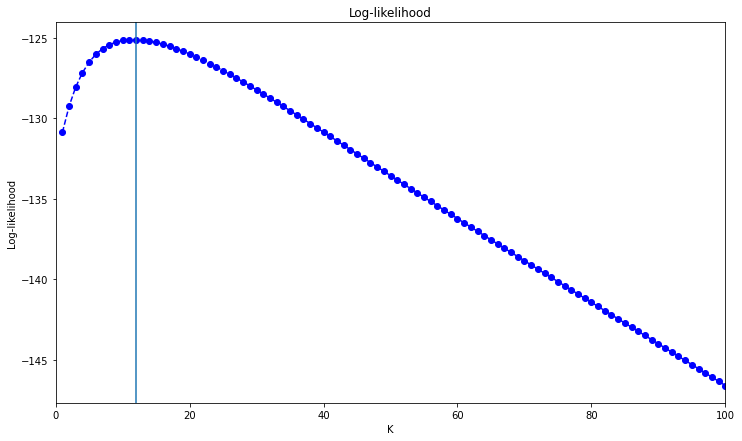

In [17]:
K = np.arange(1, 101, 1)

log_likelihoods_normal = get_loglikelihoods_for_ks(K)
plot_log_likelihood(K, log_likelihoods_normal)

# TODO: move this down to where log_likilihoods_mov is defined
# log_likelihoods_mov = get_loglikelihoods_for_ks(K, mov_flag=True)
# plot_log_likelihood(K, log_likelihoods_mov)

In [22]:
# Get simple Elo ratings using the best k-factor
baseline_elo_ratings = run_tournament(fulldf, K=bestK(log_likelihoods_normal))
baseline_elo_ratings.sort_values(by='ratings', ascending = False)[0:25]

,ratings
Eklent Kaci,1728.503376
Jayson Shaw,1719.292109
Joshua Filler,1684.539275
Niels Feijen,1675.707891
Shane Van Boening,1660.511765
Albin Ouschan,1654.108281
Fedor Gorst,1633.877830
Denis Grabe,1631.089350
Ralf Souquet,1623.422347
Mario He,1620.401416


In [23]:
# TODO: clean up / add comment
players.value_counts()[list(baseline_elo_ratings.sort_values(by='ratings', ascending = False)[0:25].index)]

Eklent Kaci               127
Jayson Shaw               131
Joshua Filler             112
Niels Feijen              159
Shane Van Boening         171
Albin Ouschan             121
Fedor Gorst                90
Denis Grabe               102
Ralf Souquet              125
Mario He                   92
David Alcaide             104
Dennis Orcollo             82
Carlo Biado                56
Maximilian Lechner         55
Alex Kazakis              109
Ko Ping-Chung              48
Mieszko Fortunski          61
Francisco Sanchez Ruiz     81
Jeffrey de Luna            48
Liu Haitao                 40
Jeffrey Ignacio            42
Wu Jiaqing                 37
Ko Pin Yi                  61
Raymund Faraon             38
Wiktor Zielinski           66
dtype: int64

In [24]:
# TODO: clean up / add comment
baseline_elo_ratings.sort_values(by='ratings', ascending = False)[len(players.value_counts())-40:len(players.value_counts())]

,ratings
Jason Theron,1478.294686
Mehdi Rasekhi,1478.275999
Chris Lawson,1478.234992
Tony Chohan,1478.137867
Michael Yednak,1478.101439
Mohammad Soufi,1477.928248
Mohammed Hassan,1477.791642
Ali Abdulhadi Almeri,1477.763336
Gabriel Syarov,1477.424372
Mohd Al Bin Ali,1477.056758


In [25]:
# TODO: clean up / add comment
players.value_counts()[list(baseline_elo_ratings.sort_values(by='ratings', ascending = False)[len(players.value_counts())-25:len(players.value_counts())].index)]

Jason Merry               4
Ken Thompson              4
Nadim Okbani              4
Lenny Rakers              4
Ali al-Obaidly           11
Carlos Cabello            4
Lefteris Georgiou        18
Gary Urinoski             4
Mark Todd                 4
Abder Rehman Mebarki      4
Mariusz Skoneczny        13
Luu Minh Phuc            11
Alejandro Carvajal        7
Meshaal al-Murdhi         7
Huidji See               11
Bashar Hussain           13
Stevie Moore              5
Gary Lutman               7
Sundeep Gulati            5
Earl Strickland          19
Adam Mscisz               8
Robert Hart               6
Kostas Koukiadakis       26
Abdul Latif al-Fawal     11
Mohammad-Ali Berjaoui     9
dtype: int64

In [26]:
# Filter ratings for players in the validation set 
val_players_ratings = baseline_elo_ratings.iloc[np.array(val_players_idx)]
# TODO: delete line below?
# CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)
val_players_ratings = val_players_ratings.set_index(pd.Index(val_players_names))
val_players_ratings.sort_values(by='ratings', ascending = False)

,ratings
Eklent Kaci,1728.503376
Niels Feijen,1675.707891
Albin Ouschan,1654.108281
Denis Grabe,1631.089350
Ralf Souquet,1623.422347
David Alcaide,1618.034167
Alex Kazakis,1602.230630
Mieszko Fortunski,1595.224044
Darren Appleton,1564.883277
Marc Bijsterbosch,1545.507106


In [27]:
get_accuracy(val_data, val_players_ratings)

0.640625

In [31]:
def get_accuracies_for_ks(K_range, tournament_type="baseline"):
    '''
    Calculate the accuracies for a range of k-factors.
    
    params
    K_range: Range of k-factors to try
    tournament_type: One of ["baseline", "mov", "initial_ratings"]. "baseline" runs the baseline Elo model, 
        "mov" runs the margin of victory adjusted Elo model, and "initial_ratings" runs the baseline Elo model 
        with initial ratings.
    
    return
    accuracies: List of accuracies per k-factor
    '''
    accuracies = []
    for k in K_range:             
        # Get ratings 
        if tournament_type == "baseline":
            allratings = run_tournament(fulldf, K=k)
        elif tournament_type == "mov":
            allratings = run_tournament_mov(fulldf, K=k)
        elif tournament_type == "initial_ratings":
            allratings = run_tournament_initial_ratings(fulldf, K=k)
        else:
            raise ValueError("Invalid tournament type")

        # Filter ratings for players in the validation set 
        val_player_ratings = allratings.iloc[np.array(val_players_idx)]
        val_player_ratings = val_player_ratings.set_index(pd.Index(val_players_names))

        accuracies.append(get_accuracy(val_data, val_player_ratings))
        
    return accuracies


def plot_accuracies(K_range, accuracies):
    '''
    Plot the accuracies and find the optimal k-factor based on accuracy.
    
    params
    K_range: Range of k-factors to try
    accuracies: List of accuracies per k-factor
    
    return
    None
    '''
    plt.figure(figsize=(12, 7))
    ax = plt.axes()
    ax.plot(K_range, accuracies, '--bo')
    bestk = accuracies.index(max(accuracies)) + 1
    ax.axvline(bestk)
    ax.set(xlim=(0, max(K_range)),
           xlabel='K', ylabel='Accuracy',
           title='Accuracies');

    print("Optimal K is " + str(bestk))
    plt.show()

Optimal K is 2


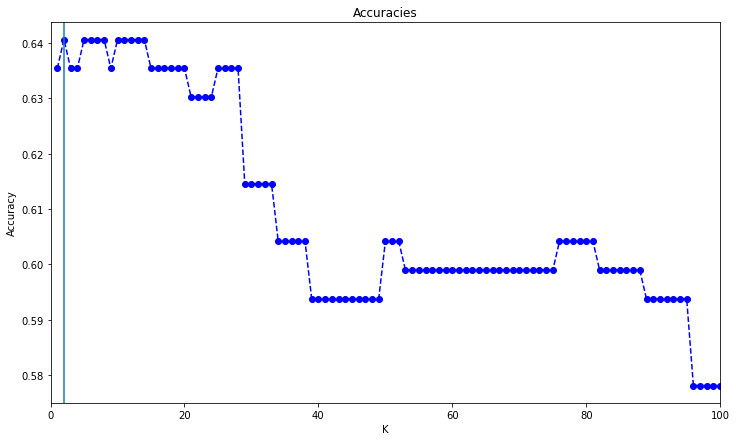

In [32]:
accuracies_normal = get_accuracies_for_ks(K)
plot_accuracies(K, accuracies_normal)

# TODO: move to the MOV section
# accuracies_mov = get_accuracies_for_ks(K, mov_flag=True)
# plot_accuracies(K, accuracies_mov)

# Margin of Victory Adjustment

In [33]:
def get_score_diff(row):
    '''
    Score difference for a match.
    
    params
    row: Match in dataframe
    
    return 
    winner: Match winner's name
    loser: Match loser's name
    '''
    return np.abs(row['playerARacks'] - row['playerBRacks'])


def run_tournament_mov(data=fulldf, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, K=K):
    '''
    Construct Elo system for 9-ball pool by running through 10 years of matches (2010-2020) with an 
    added Margin of Victory multiplier.
    
    params
    data: Dataframe of 9-ball pool matches
    INITIAL_RATING: Initial rating for all players
    ELO_WIDTH: Elo system rating change constant
    K: Update parameter
    
    return 
    ratings: Elo ratings of all players
    '''  
    players = pd.concat([data.playerA, data.playerB])
    nplayers = len(players.value_counts())

    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)) )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner, loser = get_winner_loser(row)
        
        # Update Elo ratings
        # Add margin of victory multiplier to K
        # https://math.stackexchange.com/questions/850002/improving-the-elo-rating-system-to-account-for-game-results
        mov = np.log(get_score_diff(row) + 0.5) * (2.2 / ((elo_ratings[winner] - elo_ratings[loser]) * 0.001 + 2.2))
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], K * mov, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating
        
    ratings = pd.DataFrame.from_dict(elo_ratings, orient='index')
    ratings = ratings.rename(columns={0: "ratings"})
    return ratings

Optimal K is 8


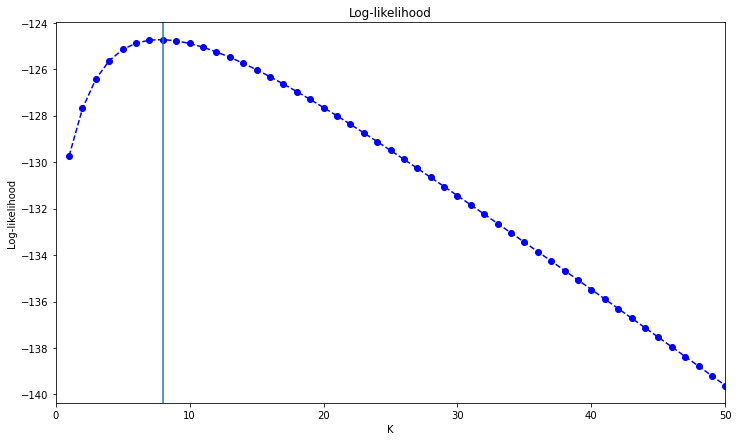

In [34]:
K = np.arange(1, 51, 1)

log_likelihoods_mov = get_loglikelihoods_for_ks(K, tournament_type="mov")
plot_log_likelihood(K, log_likelihoods_mov)

Optimal K is 9


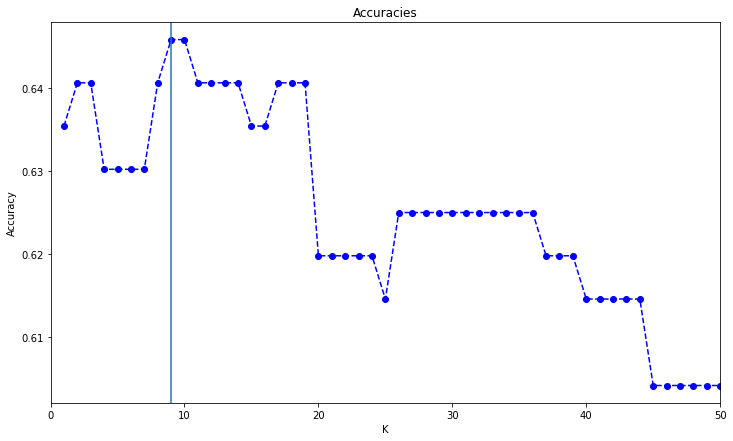

In [35]:
accuracies_mov = get_accuracies_for_ks(K, tournament_type="mov")
plot_accuracies(K, accuracies_mov)

In [36]:
# Use best K determined by maximizing the log-likelihood
mov_elo_ratings = run_tournament_mov(fulldf, K=bestK(log_likelihoods_mov))
mov_elo_ratings.sort_values(by='ratings', ascending = False)[0:25]

,ratings
Eklent Kaci,1739.942638
Joshua Filler,1702.962496
Jayson Shaw,1701.537978
Niels Feijen,1696.851596
Shane Van Boening,1671.407045
Albin Ouschan,1668.013080
Fedor Gorst,1644.316881
Denis Grabe,1627.696246
David Alcaide,1626.432302
Carlo Biado,1620.347430


In [37]:
# Filter ratings for players in the validation set 
val_players_ratings = mov_elo_ratings.iloc[np.array(val_players_idx)]
# TODO: delete line below?
# CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)
val_players_ratings = val_players_ratings.set_index(pd.Index(val_players_names))
val_players_ratings.sort_values(by='ratings', ascending = False)

get_accuracy(val_data, val_players_ratings)

0.640625

In [38]:
get_loglikelihood(val_data, val_players_ratings)

-124.7310700805685

# Initial Rating Based on Number of Games

WPA 2019 Rankings https://wpapool.com/previous-ranking/

In [39]:
fulldf.head()

,Unnamed: 0,matchIndex,date,playerA,playerARacks,playerB,playerBRacks,competition
0,0,1,2007-10-14,Shane Van Boening,11,Ronnie Alcano,4,2007 US Open 9-Ball
1,1,2,2007-10-14,Ernesto Dominguez,11,Frankie Hernandez,5,2007 US Open 9-Ball
2,2,3,2007-10-14,Tony Robles,11,Rafael Martinez,5,2007 US Open 9-Ball
3,3,4,2007-10-14,Louis Ulrich,11,Alex Pagulayan,7,2007 US Open 9-Ball
4,4,5,2007-10-14,Francisco Bustamante,11,Richie Orem,4,2007 US Open 9-Ball


In [40]:
# fulldf.head()

# players = pd.concat([fulldf.playerA, fulldf.playerB])
# print(players.value_counts().index.unique())
players_unique = players.unique()

player_to_count = dict(zip(players_unique, [0] * nplayers))
for index, row in fulldf.iterrows():
    player_to_count[row.playerA] += 1
    player_to_count[row.playerB] += 1

In [42]:
# Bottom and top 10%
bottom_10p = np.percentile(list(player_to_count.values()), 10)
top_10p = np.percentile(list(player_to_count.values()), 90)

In [43]:
def get_initial_rating_dict(players, nplayers):
    '''
    Get an initial rating dictionary for Elo ratings.
    
    params
    players: TODO
    nplayers: TODO
    
    return
    initial_rating_dict: Initial rating dictionary where the top 10% (based on number of games played) have a 
        100 point advantage and the bottom 10% have a 100 point disadvantage
    '''
    # Count the number of games per player
    player_to_count = dict(zip(players.unique(), [0] * nplayers))
    for index, row in fulldf.iterrows():
        player_to_count[row.playerA] += 1
        player_to_count[row.playerB] += 1
    
    # Bottom and top 10%
    bottom_10p = np.percentile(list(player_to_count.values()), 5)
    top_10p = np.percentile(list(player_to_count.values()), 95)

    initial_rating_dict = dict(zip(players.value_counts().index.unique(), np.repeat(INITIAL_RATING, nplayers)))
    for player, count in player_to_count.items():
        initial_rating_dict[player] = INITIAL_RATING
        if count <= bottom_10p:
            initial_rating_dict[player] -= 100
        elif count >= top_10p:
            initial_rating_dict[player] += 100
            
    return initial_rating_dict

In [44]:
def run_tournament_initial_ratings(data=fulldf, ELO_WIDTH = ELO_WIDTH, K=K):
    '''
    Construct Elo system for 9-ball pool by running through 10 years of matches (2010-2020) with 
    initialized elo ratings based on the number of games they have played.
    
    params
    data: Dataframe of 9-ball pool matches
    ELO_WIDTH: Elo system rating change constant
    K: Update parameter
    
    return 
    ratings: Elo ratings of all players
    '''  
    players = pd.concat([data.playerA, data.playerB])
    nplayers = len(players.value_counts())

    # Initialize Elo Ratings
    elo_ratings = get_initial_rating_dict(players, nplayers).copy()

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner, loser = get_winner_loser(row)
        
        # Update Elo ratings
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], K, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating
        
    ratings = pd.DataFrame.from_dict(elo_ratings, orient='index')
    ratings = ratings.rename(columns={0: "ratings"})
    return ratings

Optimal K is 7


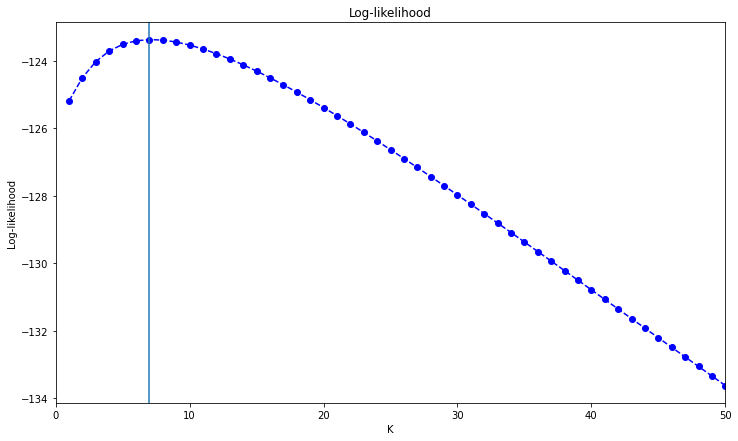

In [45]:
K = np.arange(1, 51, 1)

log_likelihoods_initial_ratings = get_loglikelihoods_for_ks(K, tournament_type="initial_ratings")
plot_log_likelihood(K, log_likelihoods_initial_ratings)

Optimal K is 2


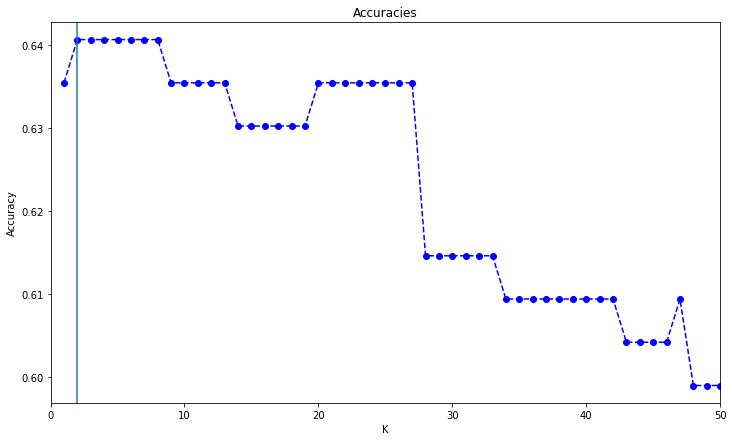

In [46]:
accuracies_initial_ratings = get_accuracies_for_ks(K, tournament_type="initial_ratings")
plot_accuracies(K, accuracies_initial_ratings)

In [47]:
# Use best K determined by maximizing the log-likelihood
initialized_elo_ratings = run_tournament_initial_ratings(fulldf, K=bestK(log_likelihoods_initial_ratings))
initialized_elo_ratings.sort_values(by='ratings', ascending = False)[0:25]

,ratings
Eklent Kaci,1724.794849
Jayson Shaw,1709.709178
Joshua Filler,1698.408708
Shane Van Boening,1691.218585
Niels Feijen,1690.708052
Albin Ouschan,1683.058435
Dennis Orcollo,1655.815320
Mario He,1655.319448
Denis Grabe,1653.979879
Fedor Gorst,1651.246567


In [48]:
# Filter ratings for players in the validation set 
val_players_ratings = initialized_elo_ratings.iloc[np.array(val_players_idx)]
# TODO: delete line below?
# CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)
val_players_ratings = val_players_ratings.set_index(pd.Index(val_players_names))
val_players_ratings.sort_values(by='ratings', ascending = False)

get_accuracy(val_data, val_players_ratings)

0.640625

In [49]:
get_loglikelihood(val_data, val_players_ratings)

-123.37801053531047

# Racks as Individual Wins

In [50]:
def get_winner_loser_and_racks(row):
    '''
    Get the winner and loser of the match. The winner is the player with more racks. Matches are played until 
    one player wins X number of racks (typically 5, 6, or 9). TODO
    
    params
    row: Match in dataframe
    
    return 
    winner: Match winner's name
    loser: Match loser's name
    '''
    if row['playerARacks'] > row['playerBRacks']: 
        winner = row["playerA"]
        loser = row["playerB"]
        win_racks = row['playerARacks']
        lose_racks = row['playerBRacks']
    else: 
        winner = row['playerB']
        loser = row['playerA']
        win_racks = row['playerBRacks']
        lose_racks = row['playerARacks']
        
    return winner, loser, win_racks, lose_racks


def run_tournament_by_racks(data=fulldf, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, K=K):
    '''
    Construct Elo system for 9-ball pool by running through 10 years of matches (2010-2020). TODO
    
    params
    data: Dataframe of 9-ball pool matches
    INITIAL_RATING: Initial rating for all players
    ELO_WIDTH: Elo system rating change constant
    K: Update parameter
    
    return 
    ratings: Elo ratings of all players
    '''  
    players = pd.concat([data.playerA, data.playerB])
    nplayers = len(players.value_counts())

    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)))

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner, loser, win_racks, lose_racks = get_winner_loser_and_racks(row)
        
        for i in range(win_racks):
            # Update Elo ratings
            new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], K, ELO_WIDTH)
            elo_ratings[winner] = new_winner_rating
            elo_ratings[loser] = new_loser_rating
            
        for i in range(lose_racks):
            # Update Elo ratings
            new_loser_rating, new_winner_rating = update_elo(elo_ratings[loser], elo_ratings[winner], K, ELO_WIDTH)
            elo_ratings[loser] = new_loser_rating
            elo_ratings[winner] = new_winner_rating
        
    ratings = pd.DataFrame.from_dict(elo_ratings, orient='index')
    ratings = ratings.rename(columns={0: "ratings"})
    return ratings

Optimal K is 5


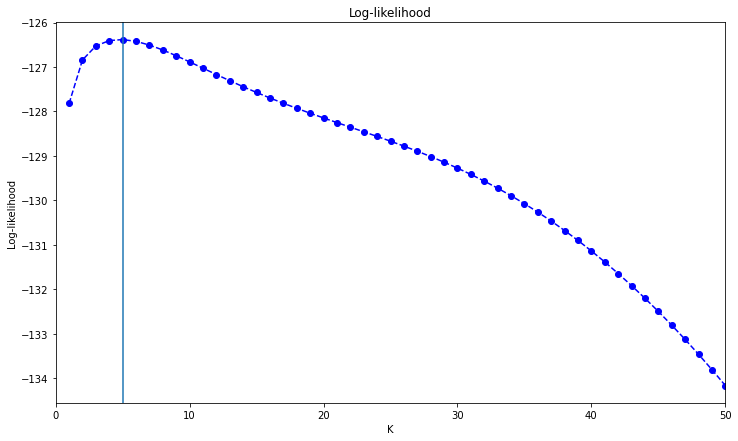

In [51]:
K = np.arange(1, 51, 1)

log_likelihoods_by_racks = get_loglikelihoods_for_ks(K, tournament_type="by_racks")
plot_log_likelihood(K, log_likelihoods_by_racks)

In [52]:
# Use best K determined by maximizing the log-likelihood
by_racks_elo_ratings = run_tournament_by_racks(fulldf, K=bestK(log_likelihoods_by_racks))
by_racks_elo_ratings.sort_values(by='ratings', ascending = False)[0:25]

,ratings
Eklent Kaci,1646.270529
Joshua Filler,1641.516634
Wu Jiaqing,1637.285445
Jayson Shaw,1630.011208
Mieszko Fortunski,1619.752451
Fedor Gorst,1615.209194
Francisco Sanchez Ruiz,1610.931449
Liu Haitao,1610.207776
Ruslan Chinakhov,1608.860638
Albin Ouschan,1608.602827


In [53]:
# Filter ratings for players in the validation set 
val_players_ratings = by_racks_elo_ratings.iloc[np.array(val_players_idx)]
# TODO: delete line below?
# CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)
val_players_ratings = val_players_ratings.set_index(pd.Index(val_players_names))
val_players_ratings.sort_values(by='ratings', ascending = False)

get_accuracy(val_data, val_players_ratings)

0.59375

In [54]:
get_loglikelihood(val_data, val_players_ratings)

-126.38270880800152

# Update Posterior Ratings after Predator CLP

In [ ]:
def run_tournament_with_prior_ratings(data, priorratings, ELO_WIDTH = ELO_WIDTH, K=bestK):
    

    # Initialize Elo Ratings
    elo_ratings = priorratings

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner, loser = get_winner_loser(row)
        k=K
#         if row['isSemi'] == True: 
#             k = K*2
#         elif row['isFinal'] == True: 
#             k = K*3
#         else: 
#             k = K
        new_winner_rating, new_loser_rating = update_elo(elo_ratings.loc[winner][0], elo_ratings.loc[loser][0], k, ELO_WIDTH)
        elo_ratings.loc[winner][0] = new_winner_rating
        elo_ratings.loc[loser][0] = new_loser_rating
    return(elo_ratings)

In [ ]:
posterior_ratings = run_tournament_with_prior_ratings(val_data, priorratings = CLPratings)

In [ ]:
posterior_ratings.sort_values(by = "ratings", ascending = False)

# FARGO

TODO: clean up and add comments

In [39]:
fargo = pd.read_csv("data/FARGOratings.csv").drop(columns= "Unnamed: 0")
fargo = fargo.set_index("player")
fargo.loc["Marc Bijsterbosch"] = 772

In [40]:
get_accuracy(val_data, fargo)

0.6145833333333334

In [41]:
get_loglikelihood(val_data, fargo)

-128.2167411794048

# WPA Rankings

TODO: clean up and add comments

In [179]:
wpaRankings = pd.read_csv("data/WPArankings.csv").drop(columns= "Unnamed: 0")
wpaRankings = wpaRankings.set_index("player")
wpaRankings

,rankings
player,
Ping Chung Ko,25263
Joshua Filler,23512
Shane Van Boening,22574
Fedor Gorst,19037
Jung-Lin Chang,19012
Ko Pin Yi,17966
Alex Pagulayan,16215
Jayson Shaw,16000
Alex Kazakis,15900


In [182]:
wpaRankings.rankings = np.log(wpaRankings.rankings)
get_loglikelihood(val_data, wpaRankings)

-133.03114392593014

In [50]:
def get_accuracy_wpa(newdata, ratings):
    '''
    Calculate the accuracy of Elo predictions on the new data.
    
    params
    newdata: Dataframe of validation data
    ratings: Elo ratings of all players
    ELO_WIDTH: Elo system rating change constant
    
    return 
    accuracy: The mean accuracy of Elo predictions
    ''' 
    accuracy = []
    # Iterate through rows of dataframe 
    for index, row in newdata.iterrows():
        playerA = ratings.loc[row.loc['playerA']][0]
        playerB = ratings.loc[row.loc['playerB']][0]
        accuracy.append(int(playerA > playerB) == int(row['playerARacks'] > row['playerBRacks']))
        
    return np.mean(accuracy)

In [51]:
get_accuracy_wpa(val_data, wpaRankings)

0.53125


# Sandbox Code 

In [70]:
# Elo Rating System 
# Constants
INITIAL_RATING = 1500
ELO_WIDTH = 400
K = 50

In [69]:
def expected(A, B, elo_width): 
    proba = 1/ ( 1 + 10 ** ((B - A) / elo_width))
    return( proba )

# https://www.kaggle.com/kplauritzen/elo-ratings-in-python
def update_elo(winner_elo, loser_elo, k, elo_width):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expected_win = expected(winner_elo, loser_elo, elo_width)
    change_in_elo = k * (1-expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

In [469]:

def run_tournament(data=fulldf, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, k=K):
    
    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)) )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner = row["WinnerName"]
        loser = row["LoserName"]
        if row['isSemi'] == True: 
            k = K*2
        elif row['isFinal'] == True: 
            k = K*3
        else: 
            k = K
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], k, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating

    return(elo_ratings)

In [470]:
ratings = run_tournament()

KeyError: 'WinnerName'

In [100]:
ratings.sort_values(by='ratings', ascending = False)

,ratings
Shannon Murphy,1475.0
Robby Foldvari,1475.0
Jang Moonseok,1475.0
Francois Ellis,1475.0
Himanshu Jain,1475.0
...,...
Albin Ouschan,800.0
Jayson Shaw,775.0
Alex Pagulayan,750.0
Dennis Orcollo,750.0


In [101]:
# Train-Test Split
winnersgroup = val_data[val_data.Group == 8]
prelims = val_data[val_data.Group != 8]

In [102]:
ratingsPrelims = run_tournament(data=prelims)

KeyError: 'Kelly Fisher'

In [103]:
ratingsPrelims
ratingsPrelims.sort_values(by='ratings', ascending = False)


NameError: name 'ratingsPrelims' is not defined

# Varying K 

In [52]:
# Elo Rating System 
# Constants
INITIAL_RATING = 0
ELO_WIDTH = 400

def expected_Glickman(A, B, elo_width): 
    proba = 1/ ( 1 + 10 ** (-1 * (A - B) / elo_width))
    return( proba )

def standard_update_elo_Glickman(Rpre, Ropp, S, k, m0, elo_width):
    expected_win = expected(Rpre, Ropp, elo_width)
    T = 14
    if (k *(S-expected_win)) <= (T * np.sqrt(m0)[0]): 
        B = 0
    else: 
        B = k *(S-expected_win) - (T * np.sqrt(m0)[0])
    Rpost = Rpre + k *(S-expected_win) + B
    return Rpost

def special_update_elo_Glickman(Rpre, Ropp, N, WL, m, elo_width):
    Rpost = (N * Rpre + m * Ropp + WL*elo_width)/(N + m)
    return Rpost





def run_tournament_varyingK(data, priorratings, priorgames, ELO_WIDTH = ELO_WIDTH, dictflag=False, consolidation = False):
    
    # Initialize Elo Ratings
    tournamentgames = pd.DataFrame(np.zeros(len( priorratings.index), dtype=int), index= priorratings.index )
    elo_ratings = priorratings
    WLrecord = pd.DataFrame(np.zeros(len( priorratings.index), dtype=int), index= priorratings.index )
    opponentrating = pd.DataFrame(np.zeros(len( priorratings.index), dtype=int), index= priorratings.index )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        playerA = row["playerA"]
        playerB = row["playerB"]
        if consolidation: 
            playerA = switcher(row["playerA"])
            playerB = switcher(row["playerB"])
            
        tournamentgames.loc[playerA] += 1
        tournamentgames.loc[playerB] += 1
        mA = tournamentgames.loc[playerA]
        mB = tournamentgames.loc[playerB]
#         print(tournamentgames)
        
        Apre = elo_ratings.loc[playerA][0]
        Bpre = elo_ratings.loc[playerB][0]
        SA = row['playerARacks'] > row['playerBRacks'] 
        SB = row['playerBRacks'] > row['playerARacks'] 
        
        if SA: 
            WLrecord.loc[playerA] += 1
        else: 
            WLrecord.loc[playerA] -= 1
            
        if SB: 
            WLrecord.loc[playerB] += 1
        else: 
            WLrecord.loc[playerB] -= 1

        if dictflag:
            NA = priorgames.loc[playerA][0]
            NB = priorgames.loc[playerB][0]
        else:
            NA = priorgames[playerA]
            NB = priorgames[playerB]
            

        
        if NA < 50: 
            ANr = 50/np.sqrt(0.662 + 0.00000739*(2569 - Apre)**2)
        else: 
            ANr = 50
        if NB < 50: 
            BNr = 50/np.sqrt(0.662 + 0.00000739*(2569 - Bpre)**2)
        else: 
            BNr = 50
            
        Ne = min(ANr, BNr)
        
        if NA <=8: 
            Apost = special_update_elo_Glickman(Apre, Bpre, NA, WLrecord.loc[playerA][0], mA, ELO_WIDTH)
        else: 
            K = 800/ (NA + Ne)
            Apost = standard_update_elo_Glickman(Apre, Bpre, SA, K, mA, ELO_WIDTH)
        
        if NB <= 8: 
            Bpost = special_update_elo_Glickman(Bpre, Apre, NB, WLrecord.loc[playerB][0], mB, ELO_WIDTH)
        else: 
            K = 800/ (NB + Ne)
            Bpost = standard_update_elo_Glickman(Bpre, Apre, SB, K, mB, ELO_WIDTH)
        
        if dictflag:
            priorgames.loc[playerA][0] += 1
            priorgames.loc[playerB][0] += 1 
        else:
            priorgames[playerA] += 1
            priorgames[playerB] += 1
        
        elo_ratings.loc[playerA][0] = Apost
        elo_ratings.loc[playerB][0] = Bpost
    return(elo_ratings)



In [53]:
players.value_counts()[np.array(names)]

Chris Melling         59
Albin Ouschan        119
Kelly Fisher           2
Eklent Kaci          117
Niels Feijen         141
Ralf Souquet         122
Chris Robinson        10
Mieszko Fortunski     59
David Alcaide        101
Darren Appleton       94
Billy Thorpe          31
Naoyuki Oi            43
Kristina Tkach         1
Roberto Gomez         17
Marc Bijsterbosch     46
Alex Kazakis          95
Casper Matikainen     24
Denis Grabe           91
Jasmin Ouschan         4
dtype: int64

In [54]:
playergames = players.value_counts()
print(playergames)



Shane Van Boening         167
Niels Feijen              141
Ralf Souquet              122
Albin Ouschan             119
Jayson Shaw               118
                         ... 
Kristina Tkach              1
Phi Le                      1
Stephen Webber              1
Reymart Lin                 1
Gindac Ciprian Gabriel      1
Length: 1182, dtype: int64


In [55]:
ratings = run_tournament_varyingK(val_data, priorratings = CLPratings, priorgames=playergames).sort_values(by='ratings', ascending = False)
ratings

,ratings
Eklent Kaci,1918.150734
Niels Feijen,1767.534626
Denis Grabe,1737.723000
Albin Ouschan,1727.830744
Mieszko Fortunski,1715.613294
David Alcaide,1714.275811
Naoyuki Oi,1675.920956
Alex Kazakis,1672.936705
Ralf Souquet,1666.393895
Casper Matikainen,1646.030959


In [56]:
allratings

,ratings
Shane Van Boening,1637.251895
Niels Feijen,1643.455154
Ralf Souquet,1601.945088
Albin Ouschan,1633.608892
Jayson Shaw,1692.910221
...,...
Kristina Tkach,1494.171065
Phi Le,1494.785533
Stephen Webber,1494.906844
Reymart Lin,1494.924111


In [57]:
# init = pd.DataFrame(np.zeros_like(allratings), index = allratings.index).rename(columns={0:'ratings'})
playersgreaterthan10 = players.value_counts()[players.value_counts() > 10]

playergamedictionary = {}

players.value_counts().index.unique()

for i in players.value_counts()[players.value_counts() <= 10].index.unique():
    if i in list(CLPratings.index):
        print(i)
        pass
    else:
        playergamedictionary[i] = "Player " + str(players.value_counts()[players.value_counts().index == i][0])

playergamedictionary
fulldf_version = fulldf.copy()
fulldf_version


Chris Robinson
Jasmin Ouschan
Kelly Fisher
Kristina Tkach


,Unnamed: 0,matchIndex,matchNumber,date,playerA,playerARacks,playerB,playerBRacks,competition
0,0,1,329B-01,2007-10-14,Shane Van Boening,11,Ronnie Alcano,4,2007 US Open 9-Ball
1,1,2,329B-02,2007-10-14,Ernesto Dominguez,11,Frankie Hernandez,5,2007 US Open 9-Ball
2,2,3,329B-03,2007-10-14,Tony Robles,11,Rafael Martinez,5,2007 US Open 9-Ball
3,3,4,329B-04,2007-10-14,Louis Ulrich,11,Alex Pagulayan,7,2007 US Open 9-Ball
4,4,5,329B-05,2007-10-14,Francisco Bustamante,11,Richie Orem,4,2007 US Open 9-Ball
...,...,...,...,...,...,...,...,...,...
4878,4878,6,NaN,2020-12-02,Jayson Shaw,5,Shane Van Boening,4,2020 Mosconi Cup
4879,4879,8,NaN,2020-12-02,Fedor Gorst,5,Corey Deuel,2,2020 Mosconi Cup
4880,4880,10,NaN,2020-12-02,Jayson Shaw,5,Billy Thorpe,3,2020 Mosconi Cup
4881,4881,12,NaN,2020-12-03,Joshua Filler,5,Skyler Woodward,0,2020 Mosconi Cup


In [58]:
playergamedictionary

{'Bora Anar': 'Player 10',
 'Robbie Capito': 'Player 10',
 'Elliott Sanderson': 'Player 10',
 'Artem Koshovyi': 'Player 10',
 'Michael Yednak': 'Player 10',
 'Satoshi Kawabata': 'Player 10',
 'Francesco Candela': 'Player 10',
 'Moritz Lauwereyns': 'Player 10',
 'Abdullah al-Yousif': 'Player 10',
 'Szu-Ting Kuo': 'Player 10',
 'Miguel Silva': 'Player 9',
 'Donny Branson': 'Player 9',
 'Kenichi Uchigaki': 'Player 9',
 'Tom Teriault': 'Player 9',
 'Jeppe Thyde': 'Player 9',
 'Raj Hundal': 'Player 9',
 'Salah Al Riwani': 'Player 9',
 'Kings Santy': 'Player 9',
 'Mustafa Alnar': 'Player 9',
 'Babken Melkonyan': 'Player 9',
 'Sean Morgan': 'Player 9',
 'Menelaos Lolas': 'Player 9',
 'Edmond Zaja': 'Player 9',
 'Attila Bezdan': 'Player 9',
 'Charlie Williams': 'Player 9',
 'John Schmidt': 'Player 9',
 'Han Haoxiang': 'Player 9',
 'Ali Maghsoud': 'Player 9',
 'Blake Baker': 'Player 9',
 'Nguyễn Anh Tuấn': 'Player 9',
 'Michael Hutcheson': 'Player 9',
 'Do The Kien': 'Player 9',
 'Pepijn DeWit'

In [59]:
def switcher(argument):
        switcher = playergamedictionary

        # get() method of dictionary data type returns 
        # value of passed argument if it is present 
        # in dictionary otherwise second argument will
        # be assigned as default value of passed argument
        val = switcher.get(argument, "nothing")
        if val == "nothing":
            return argument
        else:
#             print(val)
            return val
def consolidatestrings(series):
    
    lst = []
    for idx, item in enumerate(series): 
        lst.append(switcher(item))
#     print(lst)
    return(lst)
   
    

fulldf_version["playerA"] = consolidatestrings(fulldf_version["playerA"])
fulldf_version["playerB"] = consolidatestrings(fulldf_version["playerB"])

fulldf_version

,Unnamed: 0,matchIndex,matchNumber,date,playerA,playerARacks,playerB,playerBRacks,competition
0,0,1,329B-01,2007-10-14,Shane Van Boening,11,Ronnie Alcano,4,2007 US Open 9-Ball
1,1,2,329B-02,2007-10-14,Ernesto Dominguez,11,Player 7,5,2007 US Open 9-Ball
2,2,3,329B-03,2007-10-14,Player 1,11,Player 4,5,2007 US Open 9-Ball
3,3,4,329B-04,2007-10-14,Player 2,11,Alex Pagulayan,7,2007 US Open 9-Ball
4,4,5,329B-05,2007-10-14,Francisco Bustamante,11,Player 1,4,2007 US Open 9-Ball
...,...,...,...,...,...,...,...,...,...
4878,4878,6,NaN,2020-12-02,Jayson Shaw,5,Shane Van Boening,4,2020 Mosconi Cup
4879,4879,8,NaN,2020-12-02,Fedor Gorst,5,Corey Deuel,2,2020 Mosconi Cup
4880,4880,10,NaN,2020-12-02,Jayson Shaw,5,Billy Thorpe,3,2020 Mosconi Cup
4881,4881,12,NaN,2020-12-03,Joshua Filler,5,Skyler Woodward,0,2020 Mosconi Cup


In [60]:
filtered_list = list(set(playergamedictionary.values()))
for i in list(players.value_counts()[players.value_counts() > 10].index):
    filtered_list.append(i)

for i in players.value_counts()[players.value_counts() <= 10].index.unique():
    if i in list(CLPratings.index):
        filtered_list.append(i)
    

# filtered_list

In [61]:
# Get ratings 


init = pd.DataFrame(np.zeros(len(filtered_list)), index = index).rename(columns={0:'ratings'})
allratings = run_tournament_varyingK(fulldf_version, init + 1500, init, dictflag =True, consolidation=True)
allratings.sort_values(by='ratings', ascending = False)[0:40]


NameError: name 'index' is not defined

In [ ]:
# Get correct players
playersindex = []
names = []
for player in playersCLP.unique():
    if player in allratings.index:
        playersindex.append(np.where(players.value_counts().index == player)[0][0])
        names.append(np.where(allratings.index == player)[0][0])
playersindex
names

In [ ]:
# Games in the prior dataset
players.value_counts()[playersindex]
fullPlayerList = list(players.value_counts()[playersindex].index)
print(fullPlayerList)
# fullPlayerList.append("Kristina Tkach")
# fullPlayerList.append("Kelly Fisher")

CLPratings = allratings.iloc[np.array(names)]
print(CLPratings)
# CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)

CLPratings = CLPratings.set_index(pd.Index(fullPlayerList) )

# # Filter ratings 
# CLPratings = allratings.iloc[np.array(names)]
# # CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)
# CLPratings = CLPratings.set_index( index )
CLPratings.sort_values(by='ratings', ascending = False)

In [ ]:
def get_loglikelihood(newdata, ratings, ELO_WIDTH = ELO_WIDTH):

    loglikelihood = 0
    # Iterate through rows of dataframe 
    for index, row in newdata.iterrows():
        if row['playerARacks'] > row['playerBRacks']: 
            winner = row["playerA"]
            loser = row["playerB"]
        else: 
            winner = row['playerB']
            loser = row['playerA']
        winnerrating = ratings.loc[winner]
        loserrating = ratings.loc[loser]
        proba = expected(winnerrating, loserrating, ELO_WIDTH)   
#         print(proba)
    
        loglikelihood += math.log(proba)

        
    return(loglikelihood)

In [ ]:
get_loglikelihood(val_data, CLPratings)

In [62]:
ratings = run_tournament_varyingK(val_data, priorratings = CLPratings, priorgames=playergames).sort_values(by='ratings', ascending = False)
ratings

,ratings
Eklent Kaci,1912.123345
Niels Feijen,1761.409050
Denis Grabe,1740.461103
Albin Ouschan,1737.066198
David Alcaide,1728.970348
Mieszko Fortunski,1691.959995
Naoyuki Oi,1683.411651
Alex Kazakis,1678.863331
Ralf Souquet,1654.830472
Darren Appleton,1625.672872
